In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata
from scipy import linalg
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split as tts
from sklearn.metrics import mean_squared_error as mse

In [2]:
#Next, implement loess (non-parametric)
#Need Kernals

# Tricubic Kernel
def tricubic(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2, axis=1))
  return np.where(d>1,0,70/81*(1-d**3)**3)

# Epanechnikov Kernel - is perhaps one of the best choices
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2))
  
# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2)  


In [3]:
#Loess function
def lowess_reg(x, y, xnew, kern, tau): #xnew is test data, x is input train data, y is output train data
    # tau is called bandwidth K((x-x[i])/(2*tau))
    # IMPORTANT: we expect x to the sorted increasingly
    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the bell shape kernel function    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        #theta = linalg.solve(A, b) # A*theta = b
        theta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 
    f = interp1d(x, yest,fill_value='extrapolate')
    return f(xnew)

In [4]:
#data = pd.read_csv("/content/drive/MyDrive/Adv_Applied_Machine_Learning/Week_1/Data/cars.csv")
data = pd.read_csv("Data/cars.csv")
data

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449
...,...,...,...,...
387,27.0,4,140.0,2790
388,44.0,4,97.0,2130
389,32.0,4,135.0,2295
390,28.0,4,120.0,2625


In [5]:
x = data['WGT'].values
y = data['MPG'].values

In [6]:
#Since WGT is in the thousands but MPG is in the teens, we need to standardize the scales of the features
#Standard scalar!
from sklearn.preprocessing import StandardScaler as ss
xtrain, xtest, ytrain, ytest = tts(x,y, train_size = 0.75, random_state = 123)
scaler = ss()
xtrain_scaled = scaler.fit_transform(xtrain.reshape(-1, 1))
xtest_scaled = scaler.transform(xtest.reshape(-1, 1)) #Not fit tranform for the xtest


In [7]:
#Get them to be column vectors
xtrain_scaled = xtrain_scaled.flatten()
xtest_scaled = xtest_scaled.flatten()

print(xtrain_scaled.shape) #Even after reshaping x is noth a column vector, need to use flatten()
print(ytrain.shape)

(294,)
(294,)


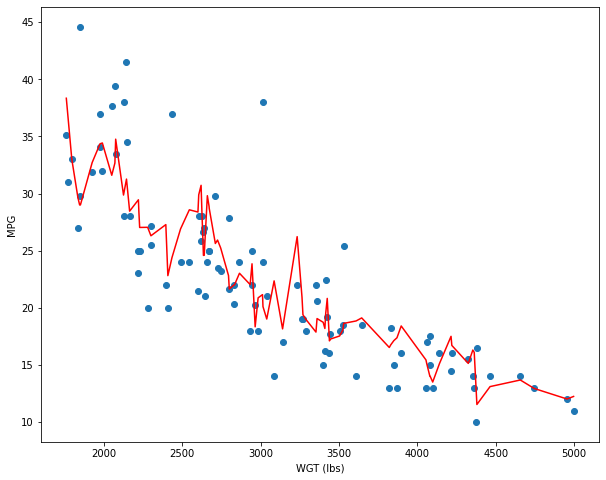

In [8]:
#Now implement loess
#Guess a tau hyper-parameter value, xnew is the xtest values
y_pred = lowess_reg(xtrain_scaled, ytrain, xtest_scaled, tricubic, tau = 0.01)

#Make into a full array and sort by x so it makes sense
data_test_loess = np.column_stack([xtest, xtest_scaled, ytest, y_pred])
data_test_sorted_loess = data_test_loess[np.argsort(data_test_loess[:,1])]

fig, ax = plt.subplots(figsize=(10,8))
plt.ylabel("MPG")
plt.xlabel("WGT (lbs)")
ax.scatter(data_test_sorted_loess[:,0], data_test_sorted_loess[:,2])
ax.plot(data_test_sorted_loess[:,0], data_test_sorted_loess[:,3], color='red')
loess_mse = mse(y_pred, ytest)

In [9]:
RFR = RandomForestRegressor(n_estimators=1000, max_depth=3, random_state=123)

RFR.fit(xtrain_scaled.reshape(-1,1), ytrain)
xtest_scaled = xtest_scaled.reshape(-1,1)
y_pred_RFR = RFR.predict(xtest_scaled)

data_test_rfr = np.column_stack([xtest, xtest_scaled, ytest, y_pred_RFR])
data_test_sorted_rfr = data_test_rfr[np.argsort(data_test_rfr[:,1])]
#print(data_test_sorted)

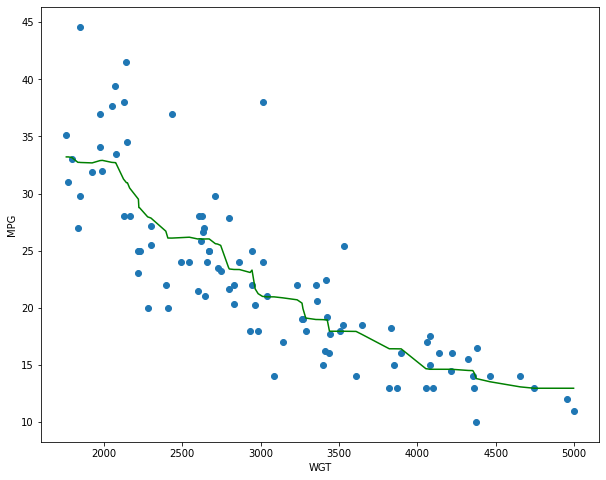

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
plt.ylabel("MPG")
plt.xlabel("WGT")
ax.scatter(data_test_sorted_rfr[:,0], data_test_sorted_rfr[:,2])
ax.plot(data_test_sorted_rfr[:,0], data_test_sorted_rfr[:,3], color='green')

rfr_mse = mse(data_test_sorted_rfr[:,2], data_test_sorted_rfr[:,3])

In [11]:
print("Loess: " + str(loess_mse))
print("RFR: " + str(rfr_mse))

Loess: 19.273591645056214
RFR: 15.86123443881256


### KFold Validation

The MSE for Random Forest is : 18.296816754411704
The MSE for Lowess is : 17.638049656558326


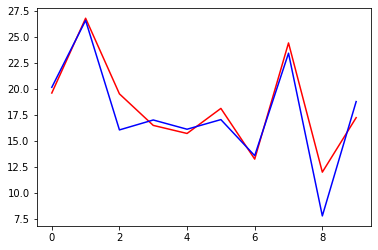

In [12]:
#Doing kfold version
data = pd.read_csv("Data/cars.csv")
x = data['WGT'].values
y = data['MPG'].values

kf = KFold(n_splits=10, shuffle=True, random_state=410)
RFR = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=410)

mse_lwr= []
mse_rfr = []

for idxtrain, idxtest in kf.split(x):
    ytrain = y[idxtrain]
    xtrain = x[idxtrain]

    xtrain = scaler.fit_transform(xtrain.reshape(-1,1))
    ytest = y[idxtest]
    xtest = x[idxtest]
    xtest = scaler.transform(xtest.reshape(-1,1))
    yhat_lwr = lowess_reg(xtrain.flatten(), ytrain, xtest.flatten(), tricubic, tau=0.2)
    
    RFR.fit(xtrain,ytrain)
    yhat_rfr = RFR.predict(xtest)
    mse_lwr.append(mse(ytest, yhat_lwr))
    mse_rfr.append(mse(ytest, yhat_rfr))
    

print('The MSE for Random Forest is : ' + str(np.mean(mse_rfr)))
print('The MSE for Lowess is : ' + str(np.mean(mse_lwr)))

plt.plot(np.arange(0,10,1),mse_rfr, color='red')
plt.plot(np.arange(0,10,1),mse_lwr, color='blue')

### KFold for Boston Housing Data

In [13]:
#Doing kfold validation for boston housing between lowess and rfr
data = pd.read_csv('Data/Boston_Housing_Prices.csv')
x = data['rooms'].values
y = data['cmedv'].values

kf = KFold(n_splits=10, shuffle=True, random_state=410)
RFR = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=410)

mse_lwr= []
mse_rfr = []

for idxtrain, idxtest in kf.split(x):
    RFR = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=410)

    ytrain = y[idxtrain]
    xtrain = x[idxtrain]
    xtrain = scaler.fit_transform(xtrain.reshape(-1,1))

    ytest = y[idxtest]
    xtest = x[idxtest]
    xtest = scaler.transform(xtest.reshape(-1,1))

    yhat_lwr = lowess_reg(xtrain.flatten(), ytrain, xtest.flatten(), tricubic, tau=0.2)
    RFR.fit(xtrain,ytrain)
    yhat_rfr = RFR.predict(xtest)
    mse_lwr.append(mse(ytest, yhat_lwr))
    mse_rfr.append(mse(ytest, yhat_rfr))

print('The Mean MSE for Random Forest is : ' + str(np.mean(mse_rfr)))
print('The Mean MSE for Lowess is : ' + str(np.mean(mse_lwr)))

The Mean MSE for Random Forest is : 37.08993706340423
The Mean MSE for Lowess is : 36.023070056918314


10


Text(0, 0.5, 'MSE Per Split')

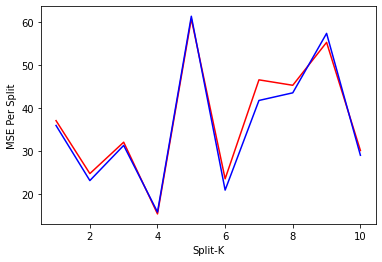

In [16]:
#Graphing the MSEs
print(len(mse_rfr))
plt.plot(np.arange(1,11,1),mse_rfr, color='red')
plt.plot(np.arange(1,11,1),mse_lwr, color='blue')
plt.xlabel('Split-K')
plt.ylabel('MSE Per Split')


### Euclidean distance in higher dimensions

In [15]:
x = np.random.uniform(low=150, high = 400, size=(100,2)) #Make fake data 
x = np.sqrt(np.sum((x-x[10])**2, axis=1)) #Euclidean Distance from x[10]
#x.sort(axis=0)

### Visualizing Random Forests

In [34]:
#Generate fake data with some noise, then apply RFR and visualize
#Making Data
x = np.arange(-2,6,0.05) #This is in increasing order, need that for plotting
y = np.sin(x**2)
#Adding some gaussian noise to y data
y_noised = y + np.random.normal(loc=0, scale=1.5, size=len(y))

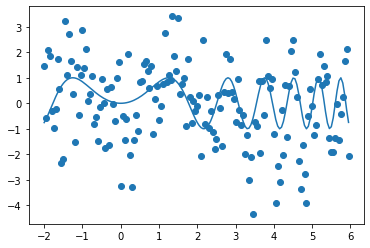

In [35]:
#Plotting
plt.scatter(x,y_noised)
plt.plot(x,y)

In [47]:
#The Model, and train test split
model = RandomForestRegressor(n_estimators=120, max_depth=3)
xtrain, xtest, ytrain, ytest = tts(x, y_noised, train_size = 0.75, random_state = 1234)
model.fit(xtrain.reshape(-1,1), ytrain.reshape(-1,1))
yhat = model.predict(xtest.reshape(-1,1))

#Putting test data into an ordered matrix, for plotting
M = np.column_stack((xtest, yhat))
M = M[np.argsort(M[:,0])] #Sorted by the first column


C:\Users\mnelk\AppData\Local\Temp/ipykernel_19280/3153502944.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain.reshape(-1,1), ytrain.reshape(-1,1))


2.995548410724262


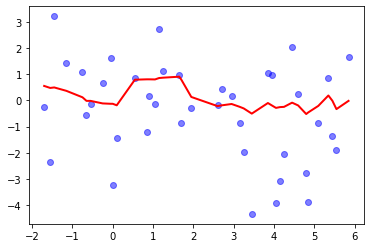

In [59]:
#Plotting
plt.scatter(xtest,ytest,color='blue',alpha=0.5)
plt.plot(M[:,0], M[:,1], color='red', lw=2)
model_mse = mse(ytest, yhat)
print(model_mse)
